<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Data-and-Function-Preparation" data-toc-modified-id="Data-and-Function-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data and Function Preparation</a></span></li><li><span><a href="#Preliminary-analysis" data-toc-modified-id="Preliminary-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preliminary analysis</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li></ul></div>

# 1.0 - Statcast Exploration
Fooling around with Statcast data

## Libraries

In [28]:
import pandas as pd
import numpy as np
import mysql.connector
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

## Data
Load data from local MySQL.

In [3]:
engine = create_engine('mysql+mysqlconnector://{username}:{password}@{host}/{db}'.format(**{
    'username': 'mlb-db',
    'password': 'password',
    'host': 'localhost',
    'db': 'mlbdb'
  }), echo=False)

In [4]:
params = {
    'year': '2017',
    'game_type': 'R'
}

In [5]:
SQL = \
"""
SELECT
  t_events.event_id AS event_id,
  t_events.batter_id AS batter_id,
  t_batter.mlb_name AS batter_name,
  t_events.pitcher_id AS pitcher_id,
  t_pitcher.mlb_name AS pitcher_name,
  t_events.at_bat_key AS at_bat_key,
  t_events.game_pk AS game_pk,
  t_events.at_bat_number AS at_bat_number,
  t_events.pitch_number AS pitch_number,
  t_events.batter_team AS batter_team,
  t_events.pitcher_team AS pitcher_team,
  t_events.batter_side AS batter_side,
  t_events.pitcher_side AS pitcher_side,
  t_events.description AS description,
  t_events.events AS events,
  t_events.bb_type AS bb_type,
  t_events.effective_speed AS effective_speed,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.release_pos_x AS release_pos_x,
  t_events.release_pos_z AS release_pos_z,
  t_events.break_horizontal AS break_horizontal,
  t_events.break_vertical AS break_vertical,
  t_events.zone AS zone,
  t_events.plate_x AS plate_x,
  t_events.plate_z AS plate_z,
  t_events.sz_top AS sz_top,
  t_events.sz_bot AS sz_bot,
  t_events.launch_speed AS launch_speed,
  t_events.launch_angle AS launch_angle,
  t_events.spray_angle AS spray_angle,
  t_events.hit_x AS hit_x,
  t_events.hit_y AS hit_y,
  t_events.hit_distance_sc AS hit_distance_sc,
  (CASE WHEN t_events.events IN ('single', 'double', 'triple', 'home_run') THEN 1 ELSE 0 END) AS hit_flag,
  (CASE WHEN t_events.events = 'home_run' THEN 1 ELSE 0 END) AS hr_flag,
  (CASE WHEN t_events.description IN ('foul', 'foul_tip', 'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'pitchout_hit_into_play', 'pitchout_hit_into_play_score', 'swinging_pitchout', 'swinging_strike', 'swinging_strike_blocked')
    THEN 1 ELSE 0 END) AS swung_flag,
  (CASE WHEN t_events.events IS NOT NULL AND t_events.events NOT IN ('caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'pickoff_1b', 'pickoff_2b', 'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home')
    THEN 1 ELSE 0 END) AS final_pitch_flag,
  (CASE WHEN t_events.launch_speed IS NOT NULL AND t_events.launch_angle IS NOT NULL AND t_events.hit_distance_sc IS NULL
    THEN 1 ELSE 0 END) AS sc_fill_flag
FROM
  (
    SELECT
      event_id,
      batter AS batter_id,
      pitcher AS pitcher_id,
      CONCAT(game_pk, at_bat_number) AS at_bat_key,
      game_pk,
      at_bat_number,
      pitch_number,
      MAX(batter_team) AS batter_team,
      MAX(pitcher_team) AS pitcher_team,
      MAX(stand) AS batter_side,
      MAX(p_throws) AS pitcher_side,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(bb_type) AS bb_type,
      MAX(effective_speed) AS effective_speed,
      MAX(release_speed) AS release_speed,
      MAX(release_spin_rate) AS release_spin_rate,
      MAX(release_pos_x) AS release_pos_x,
      MAX(release_pos_z) AS release_pos_z,
      MAX(pfx_x) AS break_horizontal,
      MAX(pfx_z) AS break_vertical,
      MAX(zone) AS zone,
      MAX(plate_x) AS plate_x,
      MAX(plate_z) AS plate_z,
      MAX(sz_top) AS sz_top,
      MAX(sz_bot) AS sz_bot,
      MAX(launch_speed) AS launch_speed,
      MAX(launch_angle) AS launch_angle,
      MAX(spray_angle_est) AS spray_angle,
      MAX(hc_x) AS hit_x,
      MAX(hc_y) AS hit_y,
      MAX(hit_distance_sc) AS hit_distance_sc
    FROM
      `mlbdb`.`statcast_extended`
    WHERE
      game_year = '{year}'
        AND game_type = '{game_type}'
    GROUP BY 1, 2, 3, 4, 5, 6, 7
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `mlbdb`.`players`
  ) t_batter
    ON (t_events.batter_id = t_batter.mlb_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `mlbdb`.`players`
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.mlb_id)
"""

In [6]:
sql = SQL.format(**params)
df_events = pd.read_sql(sql=sql, con=engine)

df_true = df_events.copy()

In [7]:
df_events.head(5)

,event_id,batter_id,batter_name,pitcher_id,pitcher_name,at_bat_key,game_pk,at_bat_number,pitch_number,batter_team,...,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
0,490098.170403_171349.1,542255,Ender Inciarte,592789,Noah Syndergaard,4900981,490098,1,1,ATL,...,20.5587,NaN,NaN,NaN,157.0,0,0,1,0,0
1,490098.170403_171407.2,542255,Ender Inciarte,592789,Noah Syndergaard,4900981,490098,1,2,ATL,...,21.2523,NaN,NaN,NaN,160.0,0,0,1,0,0
2,490098.170403_171427.3,542255,Ender Inciarte,592789,Noah Syndergaard,4900981,490098,1,3,ATL,...,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0
3,490098.170403_171457.1,621020,Dansby Swanson,592789,Noah Syndergaard,4900982,490098,2,1,ATL,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,490098.170403_171517.2,621020,Dansby Swanson,592789,Noah Syndergaard,4900982,490098,2,2,ATL,...,-24.0420,9.3,129.38,180.26,6.0,0,0,1,1,0


In [8]:
df_events.shape

(718058, 39)

## Data and Function Preparation
Creating sub-datasets and functions for later use.

In [9]:
_batted = df_events['bb_type'].notnull()
_hit = df_events['hit_flag'] == 1
_swung = df_events['swung_flag'] == 1
_final = df_events['final_pitch_flag'] == 1
_sc_fill = df_events['sc_fill_flag'] == 1
_rhb = df_events['batter_side'] == 'R'
_lhb = df_events['batter_side'] == 'L'
_rhp = df_events['pitcher_side'] == 'R'
_lhp = df_events['pitcher_side'] == 'L'

In [10]:
df_batted = df_events[_batted & ~_sc_fill]
df_hit = df_events[_hit & ~_sc_fill]
df_swung = df_events[_swung & ~_sc_fill]
df_final = df_events[_final & ~_sc_fill]
df_sof = df_events[(_swung | _final) & ~_sc_fill]
df_rhb = df_events[_rhb & ~_sc_fill]
df_lhb = df_events[_lhb & ~_sc_fill]
df_rhp = df_events[_rhp & ~_sc_fill]
df_lhp = df_events[_lhp & ~_sc_fill]
df_same_side = df_events[((_rhb & _rhp) | (_lhb & _lhp)) & ~_sc_fill]
df_oppo_side = df_events[((_rhb & _lhp) | (_lhb & _rhp)) & ~_sc_fill]

## Preliminary analysis
Looking at the "shape" of the data 

In [11]:
df_events.describe()

,at_bat_number,pitch_number,effective_speed,release_speed,release_spin_rate,release_pos_x,release_pos_z,break_horizontal,break_vertical,zone,...,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
count,718058.000000,718058.000000,714734.000000,718058.000000,703688.000000,717965.000000,717965.000000,717965.000000,717965.000000,717923.000000,...,202656.000000,126638.000000,126639.000000,126639.000000,189049.000000,718058.000000,718058.000000,718058.000000,718058.000000,718058.000000
mean,39.115732,2.909655,88.153403,88.631398,2218.656190,-0.875217,5.892194,-0.226088,0.786997,9.119286,...,15.891237,0.238295,126.166371,122.614179,164.543446,0.058525,0.008474,0.464485,0.255567,0.018965
std,23.070109,1.733654,6.325024,6.023721,309.240664,1.915642,0.481879,0.902702,0.762069,4.207186,...,29.131686,21.756464,40.262458,43.789370,121.498968,0.234733,0.091665,0.498737,0.436180,0.136402
min,1.000000,1.000000,36.030000,40.900000,413.000000,-6.504800,-0.026300,-4.150400,-4.240900,1.000000,...,-87.127200,-67.360000,6.090000,2.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.000000,83.901000,84.500000,2075.000000,-2.219600,5.622600,-0.983200,0.347800,5.000000,...,-3.811250,-17.810000,102.480000,89.500000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,3.000000,89.554000,90.000000,2241.000000,-1.569200,5.938500,-0.331000,0.940800,11.000000,...,17.261000,-0.210000,125.560000,124.750000,172.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,58.000000,4.000000,93.022000,93.300000,2403.000000,0.638700,6.208600,0.512300,1.360300,13.000000,...,36.114025,18.790000,151.710000,158.540000,257.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,146.000000,17.000000,194.574000,104.200000,3680.000000,6.567600,9.529700,2.931200,6.303600,14.000000,...,89.850000,67.440000,248.000000,248.000000,574.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Plotting
Various exploratory plots using Statcast data

In [29]:
sns.set(rc={'figure.figsize':(16,9)})

In [12]:
pal_bin = sns.diverging_palette(250, 15, n=2)

cmap_div = ListedColormap(sns.color_palette("RdBu_r", 15).as_hex())
cmap_seq = ListedColormap(sns.cubehelix_palette(25).as_hex())
cmap_bin = ListedColormap(pal_bin.as_hex())

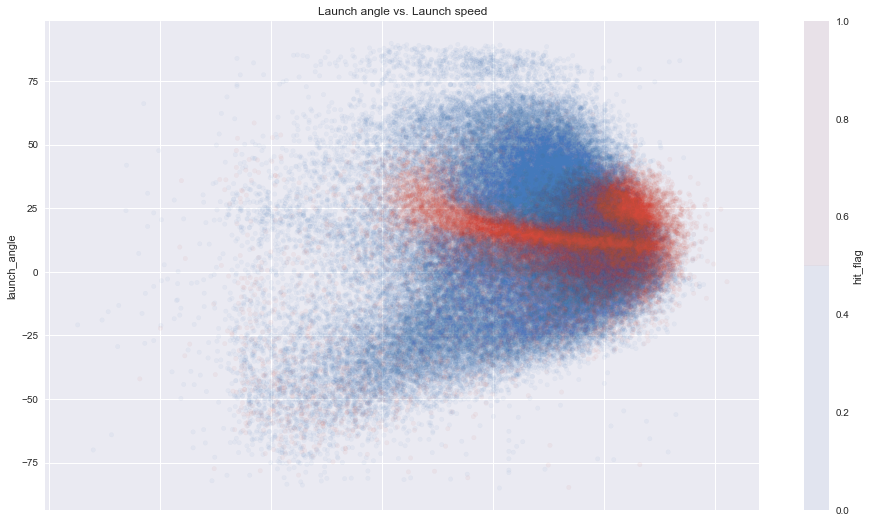

In [30]:
df_batted.plot(x='launch_speed', y='launch_angle', c='hit_flag', kind='scatter',
               colormap=cmap_bin, alpha=0.05, title='Launch angle vs. Launch speed')


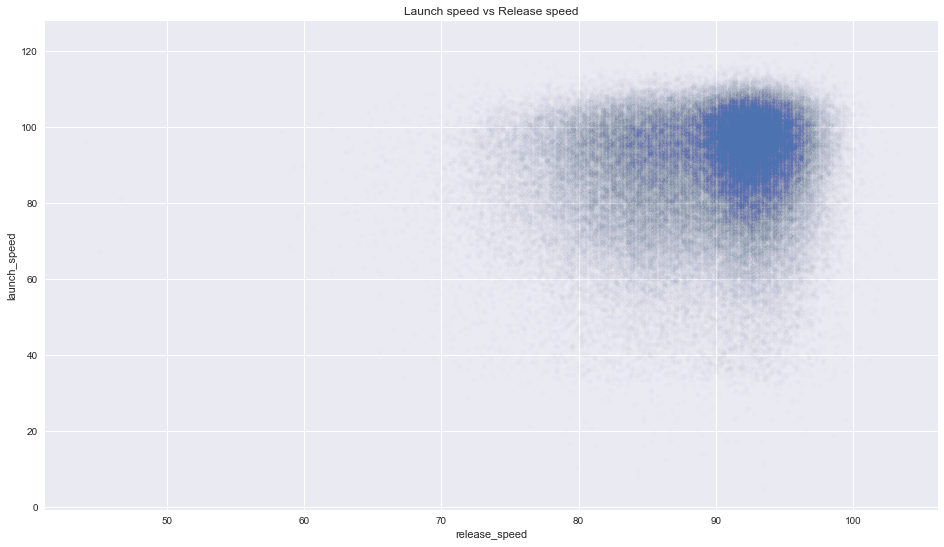

In [31]:
df_batted.plot(x='release_speed', y='launch_speed', kind='scatter', alpha=0.01,
              title='Launch speed vs Release speed')

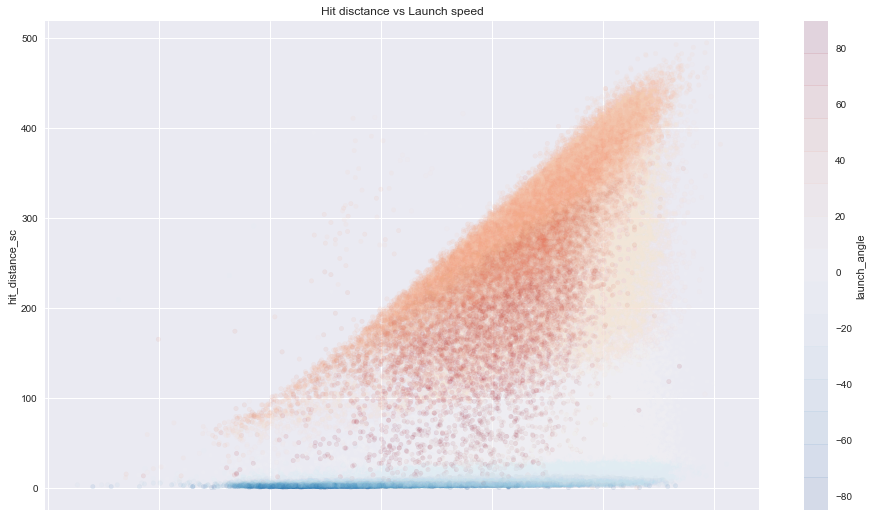

In [32]:
df_batted.plot(x='launch_speed', y='hit_distance_sc', c='launch_angle', kind='scatter',
               colormap=cmap_div, alpha=0.1, title='Hit disctance vs Launch speed')

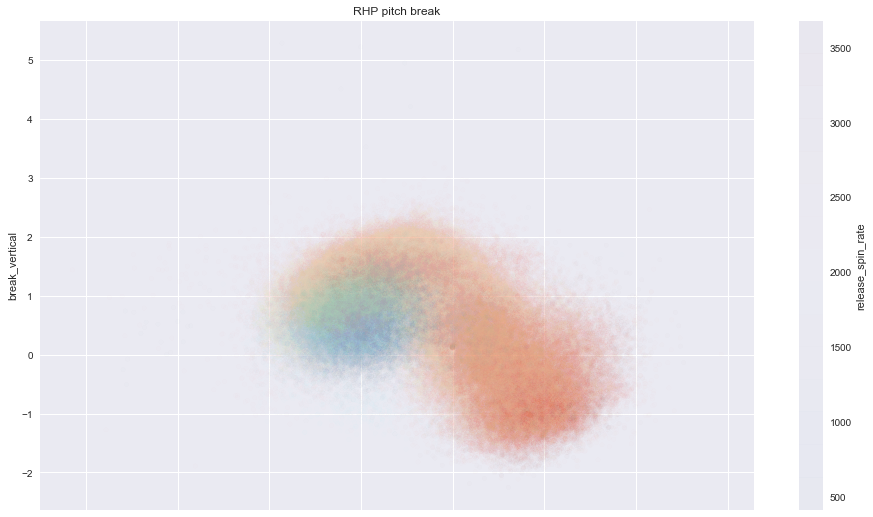

In [33]:
df_rhp.plot(x='break_horizontal', y='break_vertical', c='release_spin_rate', kind='scatter',
            colormap=cmap_div, alpha=0.01, title='RHP pitch break')

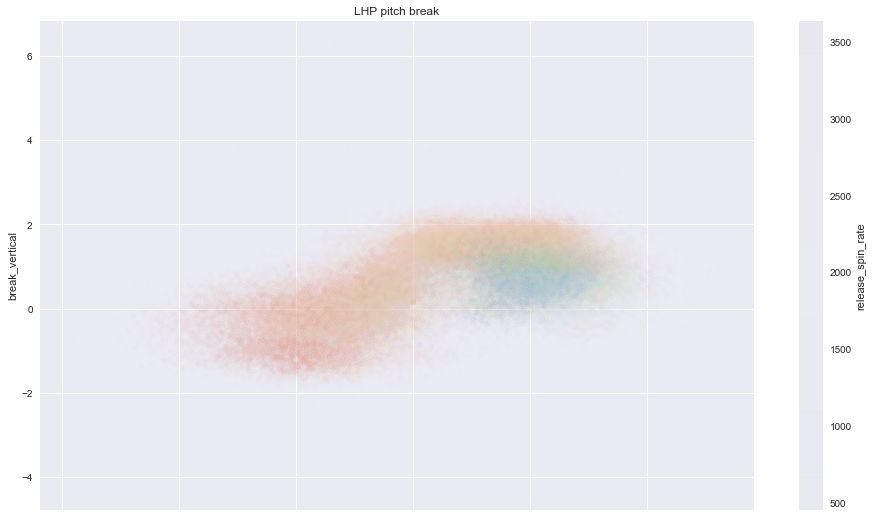

In [34]:
df_lhp.plot(x='break_horizontal', y='break_vertical', c='release_spin_rate', kind='scatter',
            colormap=cmap_div, alpha=0.01, title='LHP pitch break')

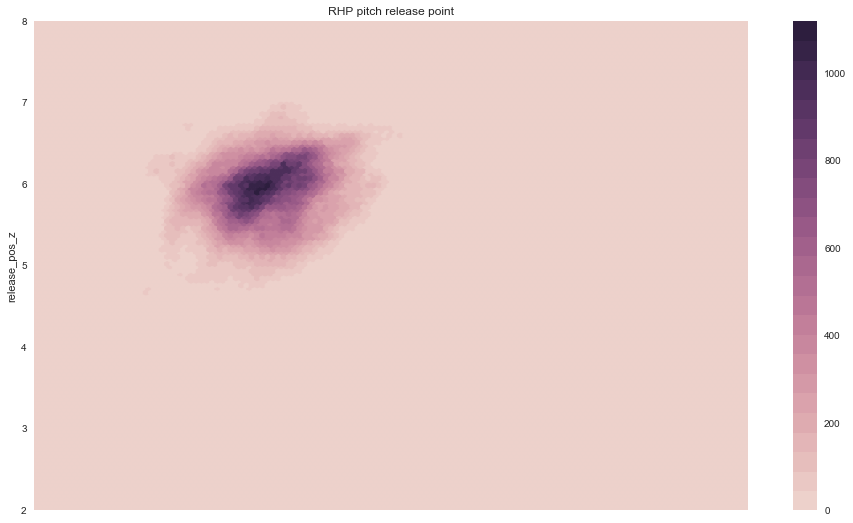

In [35]:
df_rhp.plot(x='release_pos_x', y='release_pos_z', xlim=(-5.5, 5.5), ylim=(2, 8), kind='hexbin',
            gridsize=150, colormap=cmap_seq, title='RHP pitch release point')

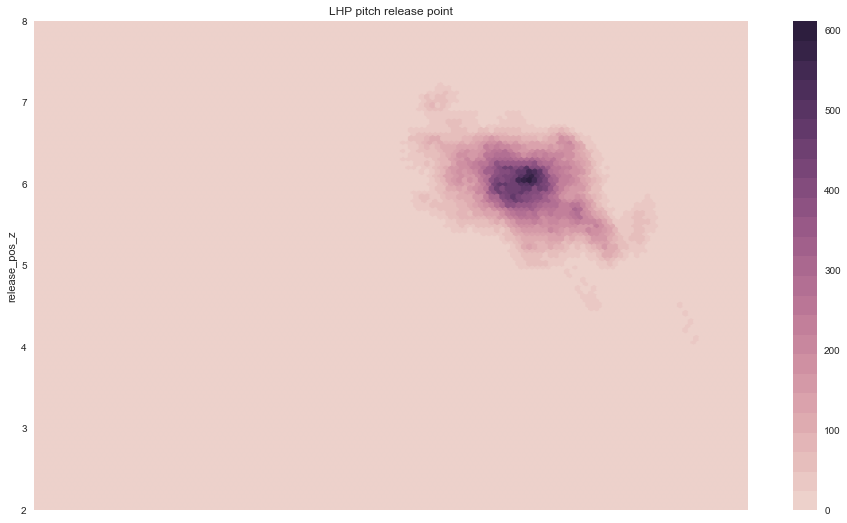

In [36]:
df_lhp.plot(x='release_pos_x', y='release_pos_z', xlim=(-5.5, 5.5), ylim=(2, 8), kind='hexbin',
            gridsize=150, colormap=cmap_seq, title='LHP pitch release point')

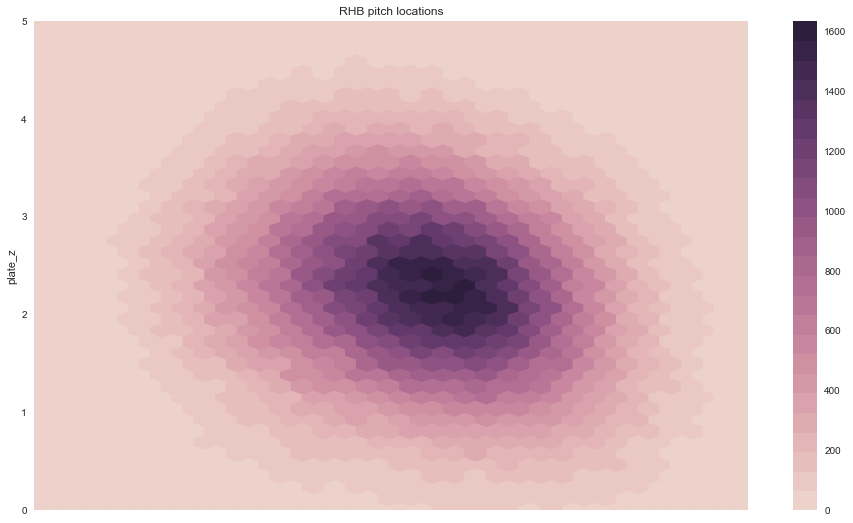

In [37]:
df_rhb.plot(x='plate_x', y='plate_z', xlim=(-2.5, 2.5), ylim=(0, 5), kind='hexbin',
            gridsize=150, colormap=cmap_seq, title='RHB pitch locations')

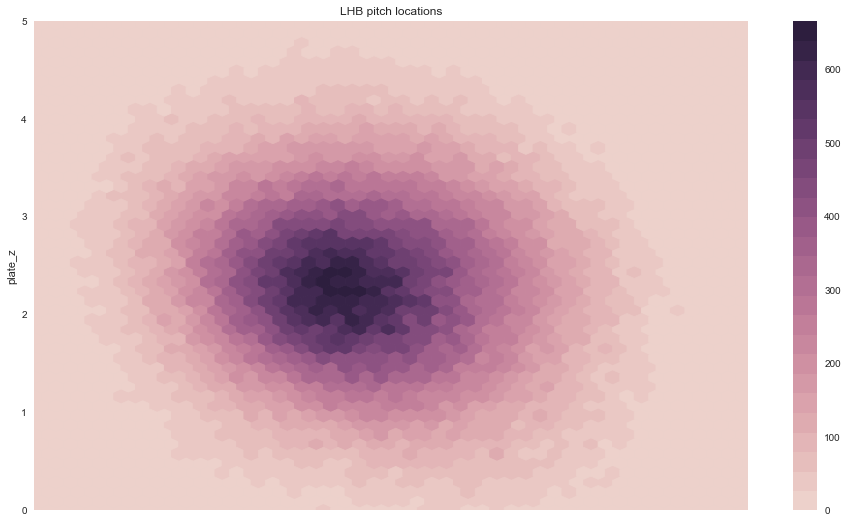

In [38]:
df_lhb.plot(x='plate_x', y='plate_z', xlim=(-2.5, 2.5), ylim=(0, 5), kind='hexbin',
            gridsize=150, colormap=cmap_seq, title='LHB pitch locations')

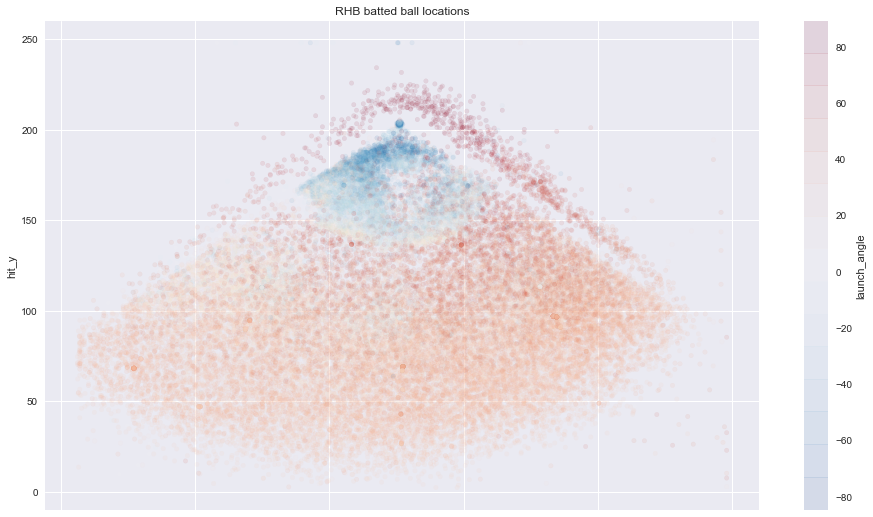

In [39]:
df_rhb.plot(x='hit_x', y='hit_y', kind='scatter', c='launch_angle', colormap=cmap_div, alpha=0.1,
           title='RHB batted ball locations')

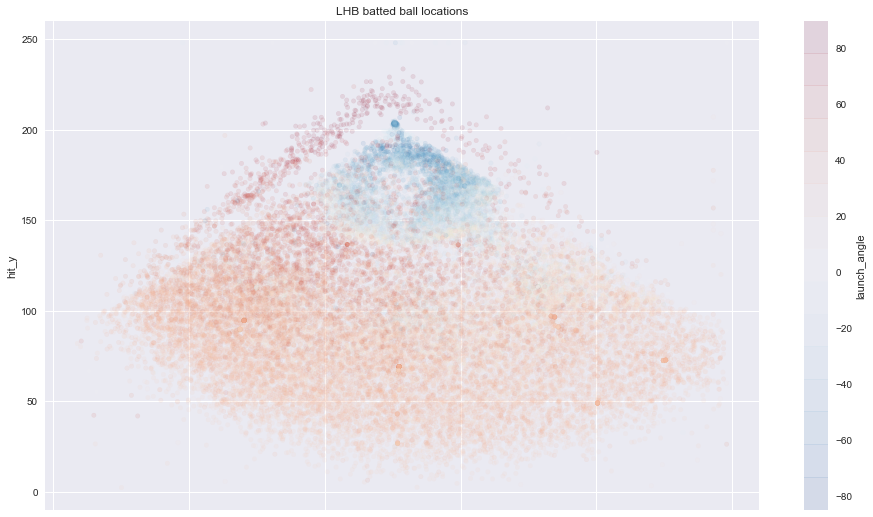

In [40]:
df_lhb.plot(x='hit_x', y='hit_y', kind='scatter', c='launch_angle', colormap=cmap_div, alpha=0.1,
           title='LHB batted ball locations')

Text(0.5,1,'Launch speed by hit result')

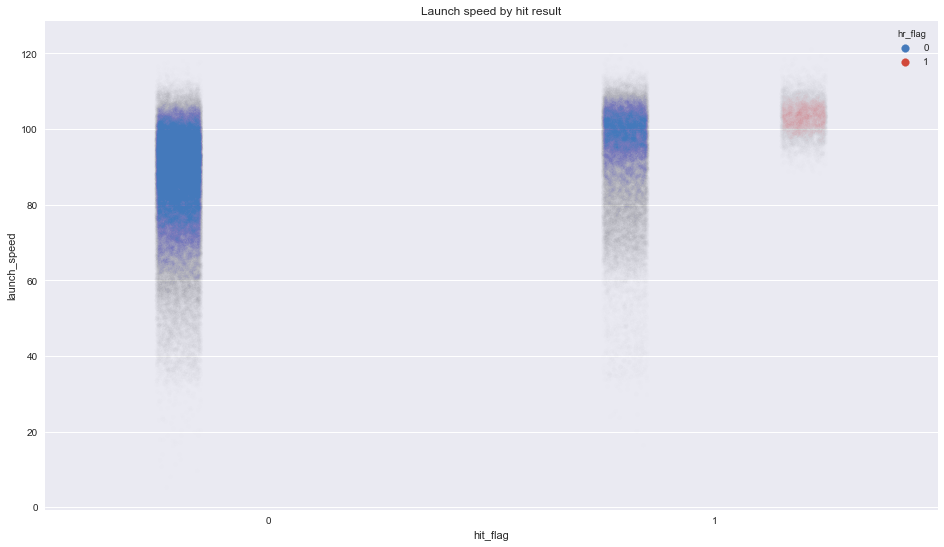

In [43]:
sns.stripplot(data=df_batted, x='hit_flag', y='launch_speed', hue='hr_flag', alpha=0.005,
              palette=pal_bin, jitter=True, dodge=True).set_title("Launch speed by hit result")

Text(0.5,1,'Launch angle by hit result')

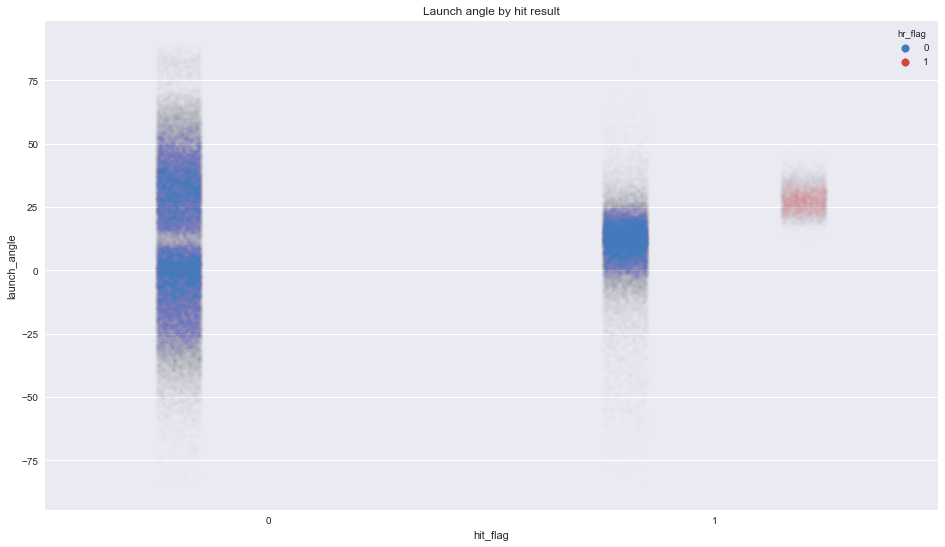

In [44]:
sns.stripplot(data=df_batted, x='hit_flag', y='launch_angle', hue='hr_flag', alpha=0.005,
              palette=pal_bin, jitter=True, dodge=True).set_title("Launch angle by hit result")

Text(0.5,1,'Hit (binary) vs launch speed')

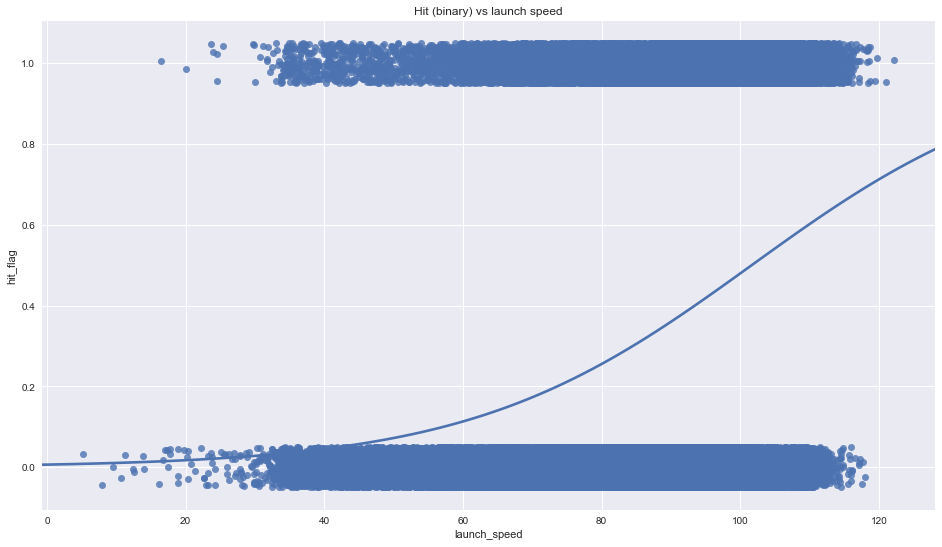

In [46]:
sns.regplot(data=df_batted, x='launch_speed', y='hit_flag', logistic=True, n_boot=100, ci=None,
            y_jitter=0.05).set_title("Hit (binary) vs launch speed")

Text(0.5,1,'HR (binary) vs launch speed')

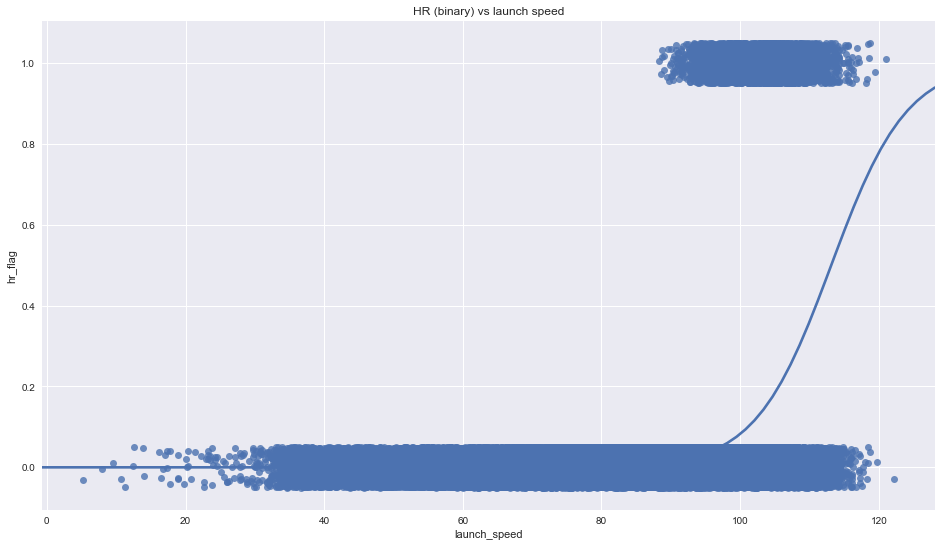

In [45]:
sns.regplot(data=df_batted, x='launch_speed', y='hr_flag', logistic=True, n_boot=100, ci=None,
            y_jitter=0.05).set_title("HR (binary) vs launch speed")